In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../")

import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=150)

from pySankey import sankey

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1200x1200 with 0 Axes>

#### helper function cluster check

In [2]:
from scipy.stats import entropy

def cluster_refine(label, label_ref, entropy_threshold = 0.75, concen_threshold = 1, max_breaks = 3):
    label_out = label.copy()
    label_out.name = label_out.name + '-refined'
    label_out = label_out.astype(str)
    ll = np.unique(label)
    for l in ll:
        ref_l = label_ref[label == l]
        ref_l_freq = ref_l.value_counts()
        if entropy(ref_l_freq) > entropy_threshold:
            for i in np.arange(max_breaks-1):
                bb = label[label_ref == ref_l_freq.index[i]]
                if entropy(bb.value_counts()) < concen_threshold:
                    label_out[(label == l) & (label_ref == ref_l_freq.index[i])] = l + '-' + str(i)
    
    return label_out.astype('category')

### another help to clean results
def clean_cluster(label):
    ll = label.value_counts().index.to_list()
    i = 0
    dd = {}
    for l in ll:
        dd[l] = str(i)
        i = i+1
    res = []
    for item in label:
        t = dd[item]
        res.append(t)
    return res

In [3]:
# read in files
cnngnn_embed = np.load("../data/double_snap_combo_stable_0327.npy")
# save out as csv
snap = pd.DataFrame(cnngnn_embed)
snap.to_csv('../data/double_snap_combo_stable_0327.csv')
#
df = pd.read_csv('../data/features_and_metadata.csv', index_col=0)
res05_input = np.load('../data/feature_labels_res0.5_0325.npy')

### convGNN clustering

In [4]:
cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))
cnngnn_adata.obs['input'] = res05_input
sc.pp.scale(cnngnn_adata)
sc.pp.neighbors(cnngnn_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(cnngnn_adata)
sc.tl.leiden(cnngnn_adata, resolution=1)
# plot
#plt.rcParams["figure.figsize"] = (8, 6)
#sc.pl.umap(cnngnn_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20')

/tmp/ipykernel_1910900/3864926844.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cnngnn_adata = ad.AnnData(utils.drop_zero_variability_columns(cnngnn_embed))


In [5]:
# cellsnap cluster guarding
snapres1 = cluster_refine(label = cnngnn_adata.obs['leiden'], label_ref=cnngnn_adata.obs['input'])
snapres1f = clean_cluster(snapres1)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'snapres1'}, xlabel='UMAP1', ylabel='UMAP2'>

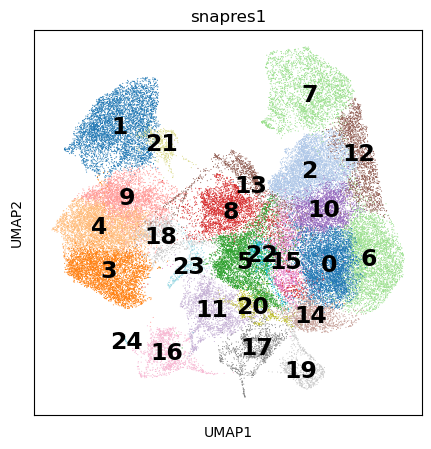

In [6]:
snapres1.value_counts()
plt.rcParams["figure.figsize"] = (5, 5)
cnngnn_adata.obs['snapres1'] = snapres1f
sc.pl.umap(cnngnn_adata, color='snapres1', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

### annotation

/tmp/ipykernel_1910900/2781527956.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = ttmp.groupby(by='snapres1').mean()


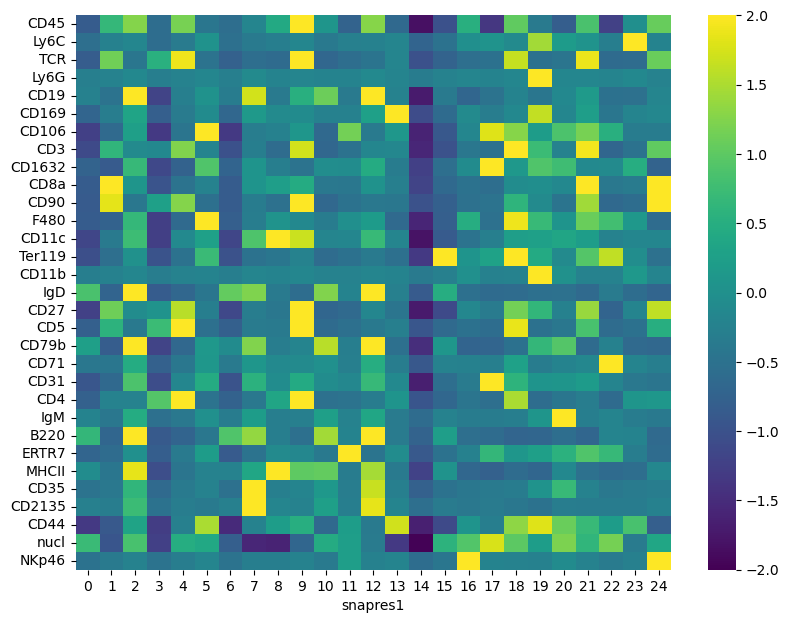

In [8]:
# annotate based on feature expressions
from scipy import stats
df_train = df
df_train['snapres1'] = cnngnn_adata.obs['snapres1'].values
ttmp = df_train.copy()
ttmp = ttmp.drop(['cellLabelInImage', 'cellSize',
                'centroid_x', 'centroid_y', 'field_of_view',
                 'cluster.term', 'cluster.termV2', 'Unnamed: 0'], axis=1)
tmp = ttmp.groupby(by='snapres1').mean()
plot = sns.heatmap((stats.zscore(tmp, axis=0, ddof=0)).T, cmap="viridis", vmin=-2, vmax=2)
fig = plot.get_figure()

plt.rcParams["figure.figsize"] = (9.6, 7.2)
fig.savefig('../plots/spleen_snapres1_heatmap_0327.svg', dpi = 150) 


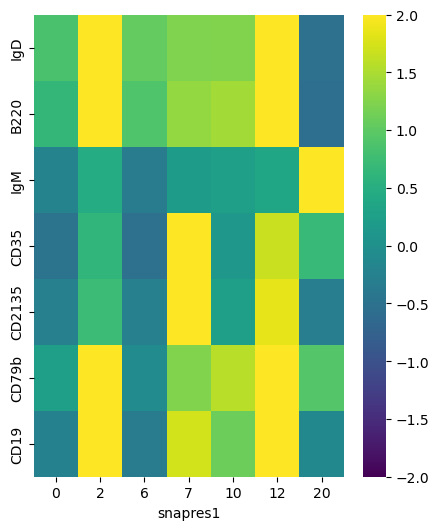

In [10]:
# also we can do a b cell only

tempb = (stats.zscore(tmp, axis=0, ddof=0)).T
#tempb
tempb = tempb.loc[['IgD', 'B220', 'IgM', 'CD35', 'CD2135', 'CD79b', 'CD19'],['0','2','6','7','10','12','20']]

plot2 = sns.heatmap(tempb, cmap="viridis", vmin=-2, vmax=2)
fig = plot2.get_figure()
plt.rcParams["figure.figsize"] = (5, 6)
fig.savefig('../plots/spleen_snapres1_heatmap_0327_Bonly.svg', dpi = 100) 


In [ ]:
## add names
df['snapres1'] = df_train['snapres1']
df['snapres1_ann'] = df_train['snapres1']

new_cluster_names = {
    '0':'B', '1':'CD8', '2':'B', '3':'CD4', '4':'CD4', '5':'Macrophage',
    '6':'B', '7':'B', '8':'DC', '9':'CD4', '10':'B', '11':'Fibro/Epi',
    '12':'B', '13':'Macrophage', '14':'Other', '15':'Erythrocyte', '16':'NK', '17':'Vessel',
    '18':'CD4', '19':'Monocyte', '20':'B', '21':'CD8', '22':'Erythrocyte', '23':'Neutrophil', '24':'NK'
}
#B : 2,3,4,6,9,11
df=df.replace({"snapres1_ann": new_cluster_names})
#df.head()
df.snapres1_ann.value_counts()

## feature clustereing

/tmp/ipykernel_1910900/2235656661.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  feature_adata = ad.AnnData(df.loc[:,features]) # remove meta info
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/m

<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

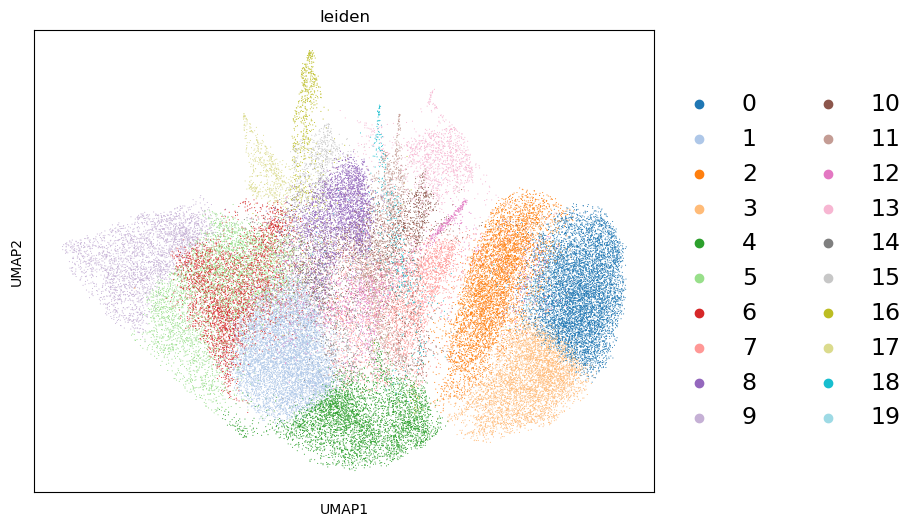

In [12]:
features = ['Ly6C', 'TCR', 'Ly6G', 'CD19',
       'CD169', 'CD106', 'CD3', 'CD1632', 'CD8a', 'CD90', 'F480', 'CD11c',
       'Ter119', 'CD11b', 'IgD', 'CD27', 'CD5', 'CD79b', 'CD71', 'CD31', 'CD4',
       'IgM', 'B220', 'ERTR7', 'MHCII', 'CD35', 'CD2135', 'CD44', 'nucl',
       'NKp46']

feature_adata = ad.AnnData(df.loc[:,features]) # remove meta info
sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1)
# plot
plt.rcParams["figure.figsize"] = (8, 6)
sc.pl.umap(feature_adata, color='leiden', legend_fontsize=17, show=False, palette='tab20')

/tmp/ipykernel_1910900/2566159042.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = ttmp.groupby(by='feature_res1').mean()


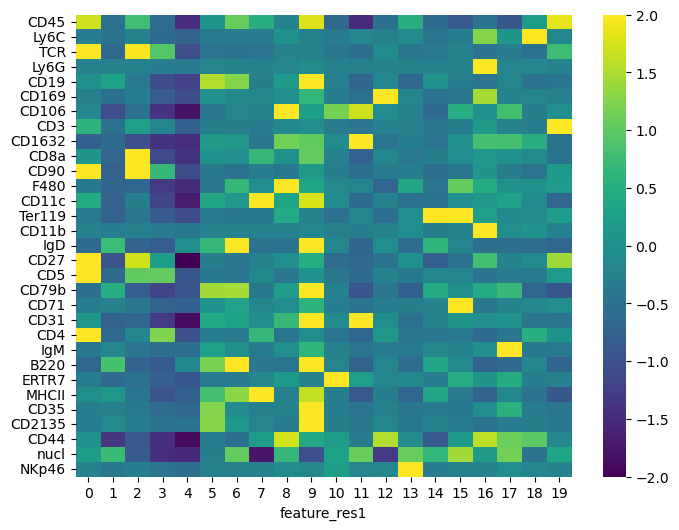

In [15]:
# annotate based on feature expressions
from scipy import stats
df_train = df
df_train['feature_res1'] = feature_adata.obs['leiden'].values
ttmp = df_train.copy()
ttmp = ttmp.drop(['cellLabelInImage', 'cellSize',
                'centroid_x', 'centroid_y', 'field_of_view',
                 'cluster.term', 'cluster.termV2', 'Unnamed: 0',
                 'snapres1', 'snapres1_ann'], axis=1)

#ttmp = ttmp.drop(['cellLabelInImage', 'cellSize',
#                'centroid_x', 'centroid_y', 'field_of_view',
#                 'cluster.term', 'cluster.termV2', 'Unnamed: 0',
#                 'snapres1'], axis=1)

tmp = ttmp.groupby(by='feature_res1').mean()
plot = sns.heatmap((stats.zscore(tmp, axis=0, ddof=0)).T, cmap="viridis", vmin=-2, vmax=2)
fig = plot.get_figure()
plt.rcParams["figure.figsize"] = (8, 6)
fig.savefig('../plots/spleen_featres1_heatmap_0327.svg', dpi = 100) 

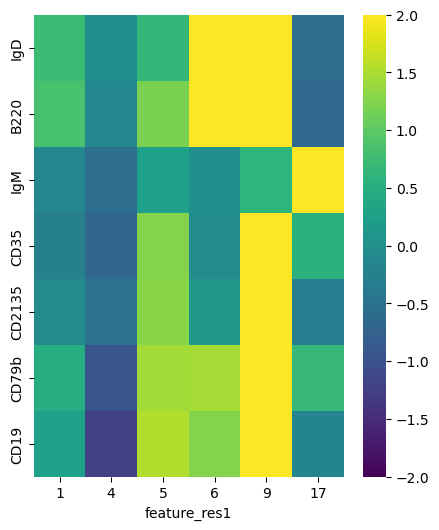

In [24]:
# also we can do a b cell only

tempb = (stats.zscore(tmp, axis=0, ddof=0)).T
#tempb
tempb = tempb.loc[['IgD', 'B220', 'IgM', 'CD35', 'CD2135', 'CD79b', 'CD19'],['1','4','5','6','9','17']]

plot2 = sns.heatmap(tempb, cmap="viridis", vmin=-2, vmax=2)
fig = plot2.get_figure()
plt.rcParams["figure.figsize"] = (5, 6)
fig.savefig('../plots/spleen_featres1_heatmap_0327_Bonly.svg', dpi = 100) 

In [ ]:
## add names
df['feature_res1'] = df_train['feature_res1']
df['feature_res1_ann'] = df_train['feature_res1']

new_cluster_names = {
    '0':'CD4', '1':'B', '2':'CD8', '3':'CD4', '4':'B', '5':'B',
    '6':'B', '7':'DC', '8':'Macrophage', '9':'B', '10':'Fibro/Epi', '11':'Vessel',
    '12':'Macrophage', '13':'NK', '14':'Erythrocyte', '15':'Erythrocyte', '16':'Monocyte', '17':'B',
    '18':'Neutrophil', '19':'CD4'
}
#B : 1,4,5,6,9,17

df=df.replace({"feature_res1_ann": new_cluster_names})
df.feature_res1_ann.value_counts()

In [17]:
df.to_csv('../data/save_spleen_ann_0328.csv')